# Medical Imaging
## 2021-2022

### Lab Introduction

Images are usually treated as 2D or 3D matrices with each element representing a single pixel or voxel. Most operations performed on images are simply extensions of the operations performed on 1D data. 

### First, let's start by importing the relevant libraries

In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from roipoly import RoiPoly
from scipy.ndimage import gaussian_filter

### 1. Loading 3D image data and getting dimensions and basic stats

In [2]:
x = loadmat('brain3D.mat')

# select variable 'im' and convert it from dictionary to numpy array
im = np.array(x['im'])

# print image size
[rows, cols, slices] = im.shape
print(rows, cols, slices)

256 256 248


### 2. Showing images

TypeError: Invalid shape (256, 256, 248) for image data

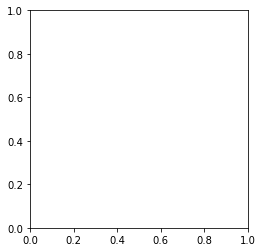

In [3]:
plt.figure(1)
plt.imshow(im)

3D images cannot be displayed, only 2D!
### 3. Selecting slices and reshaping matrices

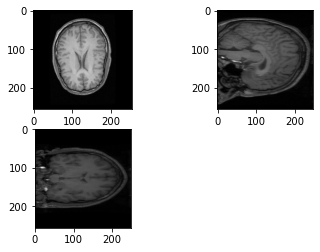

In [4]:
ax_slice = im[:,:,slices//2]
sag_slice = im[:, cols//2, :]
cor_slice = im[rows//2, :, :]


plt.figure("Mid Orthogonal Slices")
plt.subplot(2, 2, 1)
plt.imshow(ax_slice, cmap="gray")
plt.subplot(2, 2, 2)
plt.imshow(sag_slice, cmap="gray")
plt.subplot(2, 2, 3)
plt.imshow(cor_slice, cmap="gray")


The display range does not seem to be appropriate for the sagittal and coronal slices...
### 4. Exploring the image intensity and adjusting image display scale to choose a better range, it is useful to look at the histogram

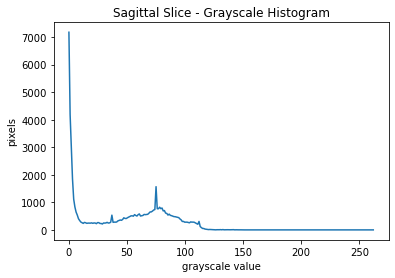

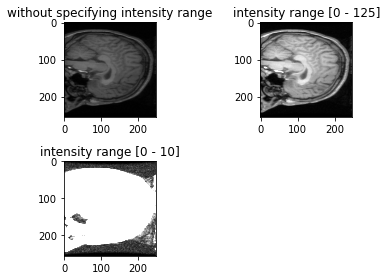

In [5]:
# create the histogram
histogram, bin_edges = np.histogram(sag_slice, bins=256)
# configure and draw the histogram figure
plt.figure()
plt.title("Sagittal Slice - Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.plot(bin_edges[0:-1], histogram)

# Let's try again setting the intensity ranges to [0 - 125]
plt.figure('Saggital Slice - readjusting scale')
plt.subplot(2, 2, 1)
plt.imshow(sag_slice, cmap='gray')
plt.title('without specifying intensity range')
plt.subplot(2, 2, 2)
plt.imshow(sag_slice, cmap='gray', vmin=0, vmax=125)
plt.title('intensity range [0 - 125]')
plt.subplot(2, 2, 3)
plt.imshow(sag_slice, cmap='gray', vmin=0, vmax=10)
plt.title('intensity range [0 - 10]')
plt.tight_layout()

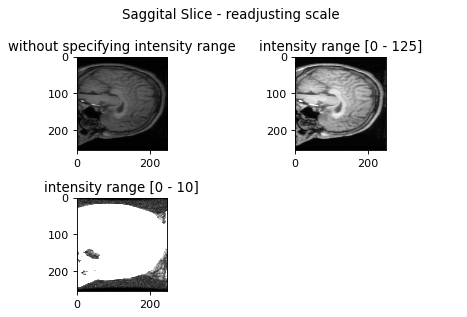

In [6]:
fig, ax = plt.subplots(2, 2,dpi=80)
plt.suptitle("Saggital Slice - readjusting scale")

ax[0, 0].imshow(sag_slice, cmap="gray")
ax[0, 0].set_title("without specifying intensity range")

ax[0, 1].imshow(sag_slice, cmap="gray", vmin=0, vmax=125)
ax[0, 1].set_title("intensity range [0 - 125]")

ax[1, 0].imshow(sag_slice, cmap="gray", vmin=0, vmax=10)
ax[1, 0].set_title("intensity range [0 - 10]")

ax[1, 1].axis("off")
plt.tight_layout()

Right, but this brain seems to be turned sideways...
### 5. Rotating 2D images

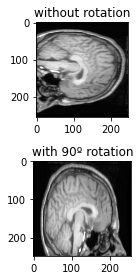

In [7]:
plt.figure('Saggital Slice - rotating 2D images')
plt.subplot(2, 1, 1)
plt.imshow(sag_slice, cmap='gray', vmin=0, vmax=125)
plt.title('without rotation')
plt.subplot(2, 1, 2)
plt.imshow(np.rot90(sag_slice), cmap='gray', vmin=0, vmax=125)
plt.title('with 90º rotation')
plt.tight_layout()

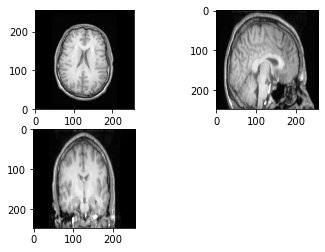

In [8]:
# That's more like it! What about the other orientations?
plt.figure('Mid Orthogonal Slices - adjusting range and rotating')
plt.subplot(2, 2, 1)
plt.imshow(ax_slice, cmap='gray', origin='lower', vmin=0, vmax=125)
plt.subplot(2, 2, 2)
plt.imshow(np.rot90(sag_slice), cmap='gray', vmin=0, vmax=125)
plt.subplot(2, 2, 3)
plt.imshow(np.rot90(cor_slice), cmap='gray', vmin=0, vmax=125)

### 6. Displaying multiple 2D images in one figure


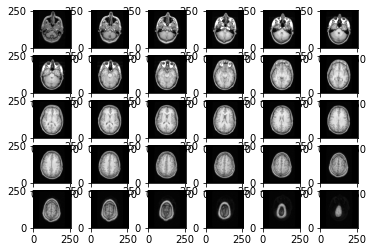

In [9]:
slice_jump = slices//30

plt.figure('Showing Multiple Slices')
for n in range(1, 31):
    sl = 1 + (n-1)*slice_jump
    axsltmp = im[:, :, sl]
    plt.subplot(5, 6, n)
    plt.imshow(axsltmp, cmap='gray', origin='lower', vmin=0, vmax=125)

### 7. Defining regions-of-interest (ROI)

In [14]:
# RoiPoly requires a different matplotlib backend
%matplotlib qt
plt.figure('Drawing an ROI')
plt.imshow(ax_slice, cmap='gray', origin='lower', vmin=0, vmax=125)
my_roi = RoiPoly(color='r')  # draw new ROI in red color
plt.imshow(ax_slice, cmap='gray', origin='lower', vmin=0, vmax=125)
my_noise = RoiPoly(color='b')

plt.imshow(ax_slice, cmap='gray', origin='lower', vmin=0, vmax=125)
my_roi.display_roi()
my_roi.display_mean(ax_slice)
my_noise.display_roi()
my_noise.display_mean(ax_slice)


/home/lsw/.local/lib/python3.10/site-packages/roipoly/roipoly.py:20: DeprecationWarning: Use 'display_roi' instead of 'displayROI'!
  warnings.warn(message, DeprecationWarning)


### 8. Calculating ROI image statistics

mask mean = 72.68 , mask stdev=37.30
noise mean = 97.30, noise stdev = 16.73


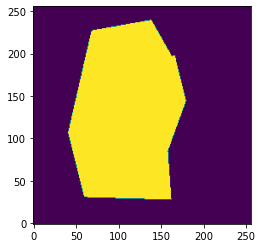

In [11]:
%matplotlib inline
mask = my_roi.get_mask(ax_slice)
mask_noise = my_noise.get_mask(ax_slice)

plt.figure()
total = mask + mask_noise
plt.imshow(total, origin='lower')

m = ax_slice[mask].mean()
s = ax_slice[mask].std()

m_noise = ax_slice[mask_noise].mean()
s_noise = ax_slice[mask_noise].std()

print("mask mean = %.2f , mask stdev=%.2f" % (m, s))
print("noise mean = %.2f, noise stdev = %.2f" % (m_noise,s_noise))

### 9. Calculating ROI image statistics

It is possible to calculate the signal-to-noise ratio (SNR) by considering also a reference region:

$$SNR_A = {mean(signal_A)}\over{std(ref)}$$.

In MRI this it often a background region, with a correction factor for noise distribution, whereas for nuclear medicine modalities the same region can be used provided the anatomy is homogeneous.

The contrast-to-noise ratio (CNR) between two tissue types would then be calculated using:
$$ CNR_{AB} = abs(SNR_A - SNR_B)$$.

Let's assume, to simplify, that we can calculate the SNR using the same region as reference.

In [12]:
snr =  m / s_noise*0.66 
print("SNR = %.2f" % (snr))

SNR = 2.87


### 10. Simulating a PSF and manipulating the spatial resolution application of a PSF as a Gaussian filter


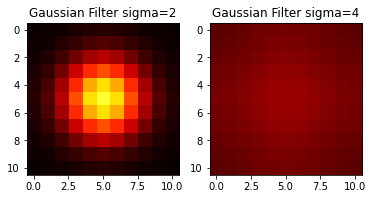

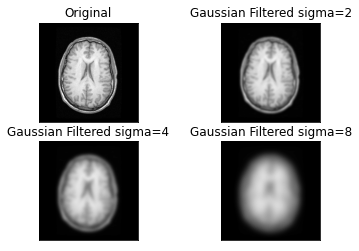

In [13]:
deltaDirac = np.zeros([11, 11])
deltaDirac[5, 5] = 1

fig = plt.figure()
plt.subplot(1, 2, 1)
psf = gaussian_filter(deltaDirac, sigma=2.0)
plt.imshow(psf, vmin=0, vmax=0.05, cmap='hot')
plt.title('Gaussian Filter sigma=2')
plt.subplot(1, 2, 2)
psf = gaussian_filter(deltaDirac, sigma=4.0)
plt.imshow(psf, vmin=0, vmax=0.05, cmap='hot')
plt.title('Gaussian Filter sigma=4')

plt.figure()
ax1 = plt.subplot(2, 2, 1)
plt.imshow(ax_slice, cmap='gray', origin='lower', vmin=0, vmax=125)
plt.title('Original')
ax2 = plt.subplot(2, 2, 2)
ax_slice_flt = gaussian_filter(ax_slice, sigma=2.0)
plt.imshow(ax_slice_flt, cmap='gray', origin='lower', vmin=0, vmax=125)
plt.title('Gaussian Filtered sigma=2')
ax3 = plt.subplot(2, 2, 3)
ax_slice_flt4 = gaussian_filter(ax_slice, sigma=4.0)
plt.imshow(ax_slice_flt4, cmap='gray', origin='lower', vmin=0, vmax=125)
plt.title('Gaussian Filtered sigma=4')
ax4 = plt.subplot(2, 2, 4)
ax_slice_flt8 = gaussian_filter(ax_slice, sigma=8.0)
plt.imshow(ax_slice_flt8, cmap='gray', origin='lower', vmin=0, vmax=125)
plt.title('Gaussian Filtered sigma=8')

# removing ticks
all_axes = [ax1, ax2, ax3, ax4]
for ax in all_axes:
    ax.set_xticks([])
    ax.set_yticks([])